In [1]:
import networkx as nx
import preprocessing as prep
import numpy as np
import pandas as pd
import numpy as np
import json
import os
import datetime
import pytz
import matplotlib.pyplot as plt
from collections import Counter
from bb_binary import load_frame_container, Repository
from pandas import Series, DataFrame

In [2]:
%matplotlib inline

In [3]:
graph_files = os.listdir()
graph_files = [g for g in graph_files if g.endswith('.graphml') & g.startswith('2015-')]

In [4]:
graph_files

['2015-08-21T03:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T20:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T09:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T05:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T23:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T16:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T19:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T07:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T08:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T21:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T00:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T22:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T17:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T12:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml',
 '2015-08-21T04:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graph

# Network Analysis - Example: One hour Network
* Confidence 0.99, 160px radius, 6 frames as intractionlength.
* hour-Networks 21.08.2015
* 2015-08-21T12:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml

In [5]:
# graph_list = []

# for eg in graph_files:
#     G = nx.read_graphml(eg)
#     date = eg.split("_")[0]
#     date_dt = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
#     date_ts = date_dt.timestamp()
#     graph_list.append((date_dt,G))

# G = graph_list[0][1]

In [103]:
G = nx.read_graphml("2015-08-21T19:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml")

## Global Properties

### Nodes, Edges, average Degree and Density

In [104]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 760\nNumber of edges: 5163\nAverage degree:  13.5868'

In [105]:
len(G.nodes())

760

In [106]:
len(G.edges())

5163

In [107]:
Series(G.degree()).mean()

13.586842105263157

In [108]:
density = nx.density(G)
density

0.017900977740794674

### Degree distribution

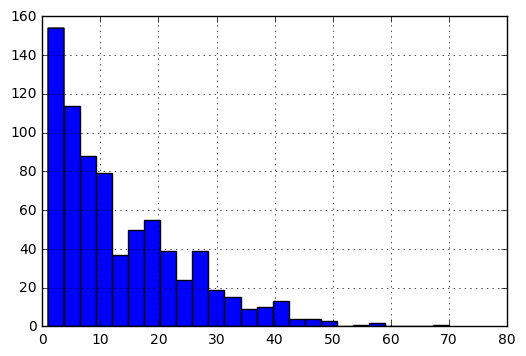

In [109]:
degrees = G.degree().values()
s = Series(list(degrees))
s.hist(bins=25)

In [110]:
s.describe()

count    760.000000
mean      13.586842
std       11.389052
min        1.000000
25%        4.000000
50%       10.000000
75%       20.000000
max       70.000000
dtype: float64

### Edge weights distribution

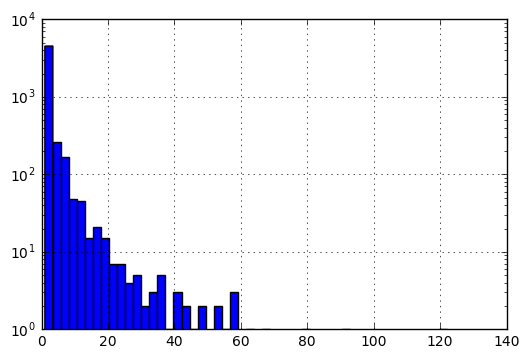

In [111]:
l = []

for e in G.edges():
    l.append(G.get_edge_data(e[0],e[1]).get("weight"))

edge_weights = Series(l)

fig, ax = plt.subplots()
ax.set_yscale('log')
edge_weights.hist(bins=50)

In [112]:
edge_weights.describe()

count    5163.000000
mean        2.354251
std         4.790640
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       122.000000
dtype: float64

### Weighted Degree Distribution

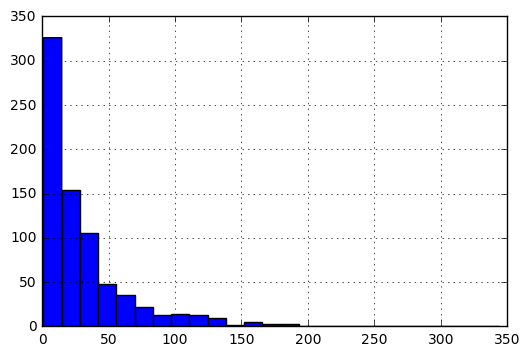

In [113]:
degrees = G.degree(weight='weight').values()
s = Series(list(degrees))
s.hist(bins=25)

### Number of components and size distribution

In [114]:
Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print("Number of components: {}".format(len(Gcc)))

size_components = []
for comp in Gcc:
    size_components.append(nx.number_of_nodes(comp))
    
Counter(list(size_components))

Number of components: 2


Counter({2: 1, 758: 1})

In [121]:
# keepthe biggest Component
G = Gcc[0]

There is one big component!

### Diameter

In [122]:
diameter = nx.diameter(G)
print("Diameter: {}".format(diameter))

Diameter: 8


### Global clustering coefficient

In [123]:
cc = nx.average_clustering(G)
cc

0.14717211754422568

### Average shortest path length

In [124]:
average_shortest_path = nx.average_shortest_path_length(G)

In [125]:
print("Average shortest path: {}".format(average_shortest_path))

Average shortest path: 3.1483567616929764


## Compare to Random Graph Model
* degree distribution (not biniminal/poisson) - ja sieht nicht binominalverteilt aus, sieht ziemlich nach scale free, wenige hubs, viele knote mit wenig links
* connectedness (giant component) - ja sieht ziemlich verbunden aus alles, gibt nur eine große komponente
* average path length (~diameter) - ist hier auch ziemlich klein, Small-world phenomenon, $d = \frac{\ln nodes}{\ln av degree}$
* clustering coefficient - müsste höher sein als bei einem random network, jep ist es auch

In [126]:
random_g = nx.erdos_renyi_graph(n=nx.number_of_nodes(G), p=density)
nx.info(random_g)

'Name: gnp_random_graph(758,0.017900977740794674)\nType: Graph\nNumber of nodes: 758\nNumber of edges: 5063\nAverage degree:  13.3588'

In [127]:
nx.average_clustering(random_g)

0.017860279937634213

In [128]:
nx.average_clustering(G)

0.14717211754422568

## Local Structure (node level metrics)

### Betweennes Centrality

In [129]:
bc = nx.betweenness.betweenness_centrality(G)

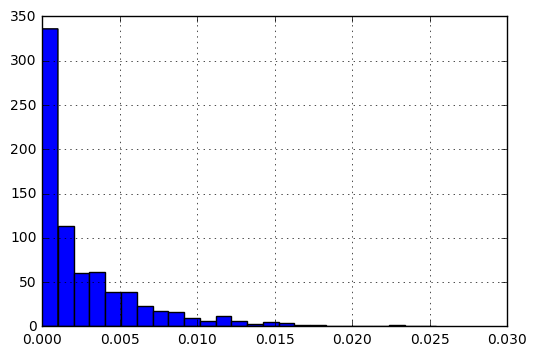

In [130]:
Series(bc).hist(bins = 25)

### Degree Centrality

In [131]:
dc = nx.degree_centrality(G)

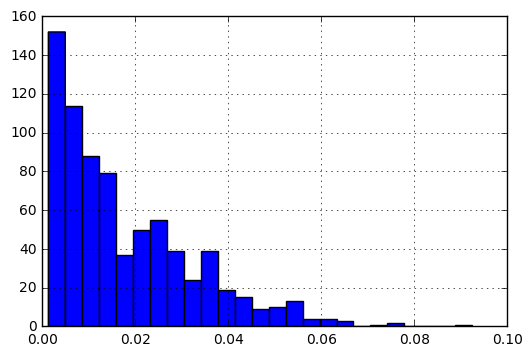

In [132]:
Series(dc).hist(bins = 25)

### Closeness Centrality

In [133]:
closenessc = nx.closeness.closeness_centrality(G)

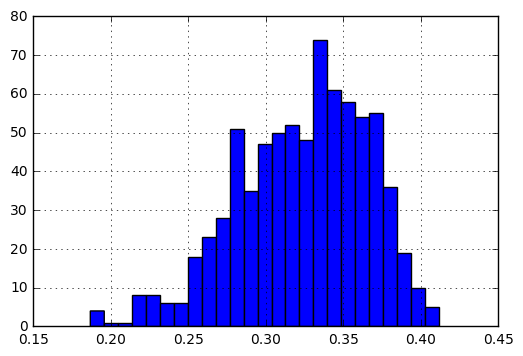

In [134]:
Series(closenessc).hist(bins=25)

### Eigenvector Centrality

In [135]:
# Kernel will die!
# ec = nx.eigenvector_centrality_numpy(G)

## Communities

In [136]:
k = 5
kcc = list(nx.community.k_clique_communities(G,k))

In [137]:
len(kcc)

43

In [102]:
[len(c) for c in kcc].sort()